In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 16)
!date

%load_ext autoreload
%autoreload 2

Sat Mar  7 20:51:54 PST 2020


# Supplementary Appendix Calcs for Census DP E2E Paper (part 2)

TopDown includes invariants, which are a feature that goes beyond the traditional formulation of epsilon-DP. As a final example, we consider how an invariant can produce an EPL that is greater than the privacy loss budget epsilon that is formally proven for the algorithm without invariants. To achieve this, we revert to the original example of stratified counts with geometrically distributed variation added to achieve epsilon-DP, and to this we add invariants at the enumeration district level.  We then use the same optimization formulated in the previous example, but with equality constraints for the total counts of each enumeration district instaead of additional terms in the objective function. [[optimization]]  This shows that EPL can be larger than epsilon when the presence of the invariant is substantially compromising the privacy of the algorithm. [[table X shows the epsilon and EPL for a range of values.]]

In [2]:
import dp_2020_census.data, dp_2020_census.model

In [3]:
df_orig = dp_2020_census.data.load_orig_counts()

In [4]:
df_orig

,state,county,enum_dist,gq,age,race,eth,count
0,2,3000,10,1,18,1,1,85
1,2,3000,10,1,17,1,1,7
2,2,3000,10,1,18,2,1,1
3,2,3000,10,1,18,3,1,1
4,2,3000,10,1,17,3,1,3
...,...,...,...,...,...,...,...,...
825431,56,450,160,1,17,1,1,68
825432,56,450,160,1,18,1,2,1
825433,56,455,10,1,18,1,1,325
825434,56,455,10,1,17,1,1,87


In [5]:
total_cnt_orig = df_orig[(df_orig.state == 53)].groupby(['state', 'county', 'enum_dist'])['count'].sum()
total_cnt_orig

state  county  enum_dist
53     10      10            348
               20            227
               30             79
               40            121
               50            181
                            ... 
       770     1330         1642
               1340         1157
               1350         1378
               1360          145
               1370          415
Name: count, Length: 2663, dtype: int64

In [6]:
county_total_cnt = df_orig[(df_orig.state == 53)].groupby(['state', 'county'])['count'].sum()

In [7]:
stratification_cols = ['state', 'age', 'race', 'eth']
col_vals = []
for col in stratification_cols:
    col_vals.append(df_orig[(df_orig.state == 53)][col].unique())

In [8]:
col_vals

[array([53]), array([18, 17]), array([1, 5, 2, 6, 3, 4]), array([1, 2])]

In [9]:
t = df_orig[(df_orig.state == 53)].groupby(['state', 'county', 'enum_dist', 'age', 'race', 'eth'])['count'].sum().reset_index()
t.shape

(9869, 7)

In [10]:
t = pd.merge(total_cnt_orig.reset_index(),
             pd.Series(0, index=pd.MultiIndex.from_product(col_vals, names=stratification_cols)).reset_index(),
             on='state', how='outer')
all_zeros = t.groupby(['state', 'county', 'enum_dist', 'age', 'race', 'eth'])[0].sum()
all_zeros.shape

(63912,)

In [11]:
strat_cnt_orig = df_orig[(df_orig.state == 53)].groupby(['state', 'county', 'enum_dist', 'age', 'race', 'eth'])['count'].sum()
strat_cnt_orig = strat_cnt_orig.add(all_zeros, fill_value=0)
strat_cnt_orig.shape

(63912,)

In [12]:
# set randoms seed for reproducibility
np.random.seed(12345)

In [13]:
epsilon = 0.25
strat_cnt_gdpc = dp_2020_census.model.GDPC(epsilon/2, strat_cnt_orig)
strat_cnt_gdpc

state  county  enum_dist  age  race  eth
53     10      10         17   1     1      157.0
                                     2       -4.0
                               2     1      -23.0
                                     2      -13.0
                               3     1        1.0
                                            ...  
       770     1370       18   4     2        0.0
                               5     1       -4.0
                                     2       -4.0
                               6     1       17.0
                                     2        1.0
Length: 63912, dtype: float64

In [14]:
import pyomo.environ
from pyomo.core import *
from pyomo.opt import SolverFactory

In [19]:
def nonneg_optimized_counts(total_counts, strat_counts):
    """optimize the stratified counts so that they are consistent with the enum_dist total and are non-negative
    
    Parameters
    ----------
    total_counts : pd.Series of floats
    strat_counts : pd.Series of floats
    
    Results
    -------
    returns optimized_total_counts, where noisy counts are optimized
    to be very close to total and also close to stratified counts and not be negative
    """
    
    model = ConcreteModel()
    model.I = range(len(strat_counts))

    model.x = Var(model.I, within=NonNegativeReals, initialize=0)
    
    model.tc = []
    obj_expr_list = []
    for i, df_i in strat_counts.reset_index().groupby(['state', 'county']):
        model.tc.append(sum(model.x[ii] for ii in df_i.index))
        obj_expr_list.append(100*(sum(model.x[ii] for ii in df_i.index) - total_counts[i])**2)
        for ii in df_i.index:
            obj_expr_list.append((model.x[ii] - strat_counts.iloc[ii])**2)
    model.objective = Objective(expr = sum(obj_expr_list))
    
    solver = SolverFactory('ipopt')
    options = {#'acceptable_tol':.01, # https://www.coin-or.org/Bonmin/option_pages/options_list_ipopt.html
#                'resto_failure_feasibility_threshold': 1e-3,
#                'bound_push':1e-9,  # from https://list.coin-or.org/pipermail/ipopt/2013-April/003319.html
#                'bound_frac':1e-9, # as above
#                'report_mininfeas_solution': 'yes', # from http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.589.5002&rep=rep1&type=pdf
              }
    results = solver.solve(model, options=options, tee=True)
    optimized_counts = np.array([value(model.x[i]) for i in model.I])
        
    return optimized_counts
np.round(nonneg_optimized_counts(county_total_cnt, strat_cnt_gdpc.iloc[:1_000]),1)

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   228628

Total number of variables............................:     1000
                     variables with only lower bounds:     1000
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

array([147. ,   0. ,   0. ,   0. ,   0. ,   0. ,  10. ,   0. ,   0. ,
         0. ,   0. ,   0. , 194. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  45. ,   0. ,  26. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
       161. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,  16. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   3. ,   0. ,  37. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   1. ,   0. ,  17. ,   0. ,   0. ,   0. ,
        17. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   6. ,   5. ,
         0. ,   0. ,   0. ,  73. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   3. ,   0. ,   0. ,   6. ,  50. ,   2. ,   7. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   4. ,
       118. ,   0. ,   0. ,   0. ,   7. ,   0. ,   0. ,  13. ,   0. ,
         0. ,   0. ,   0. ,  22. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,

In [20]:
%%time

strat_cnt_opt = nonneg_optimized_counts(county_total_cnt, strat_cnt_gdpc)
strat_cnt_opt.shape

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:101253876

Total number of variables............................:    63912
                     variables with only lower bounds:    63912
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

In [24]:
error = strat_cnt_opt - strat_cnt_orig
df_epl = dp_2020_census.model.empirical_privacy_loss(
    error, bandwidth=0.1, est_range_percentile=95, est_range_multiplier=1.0)

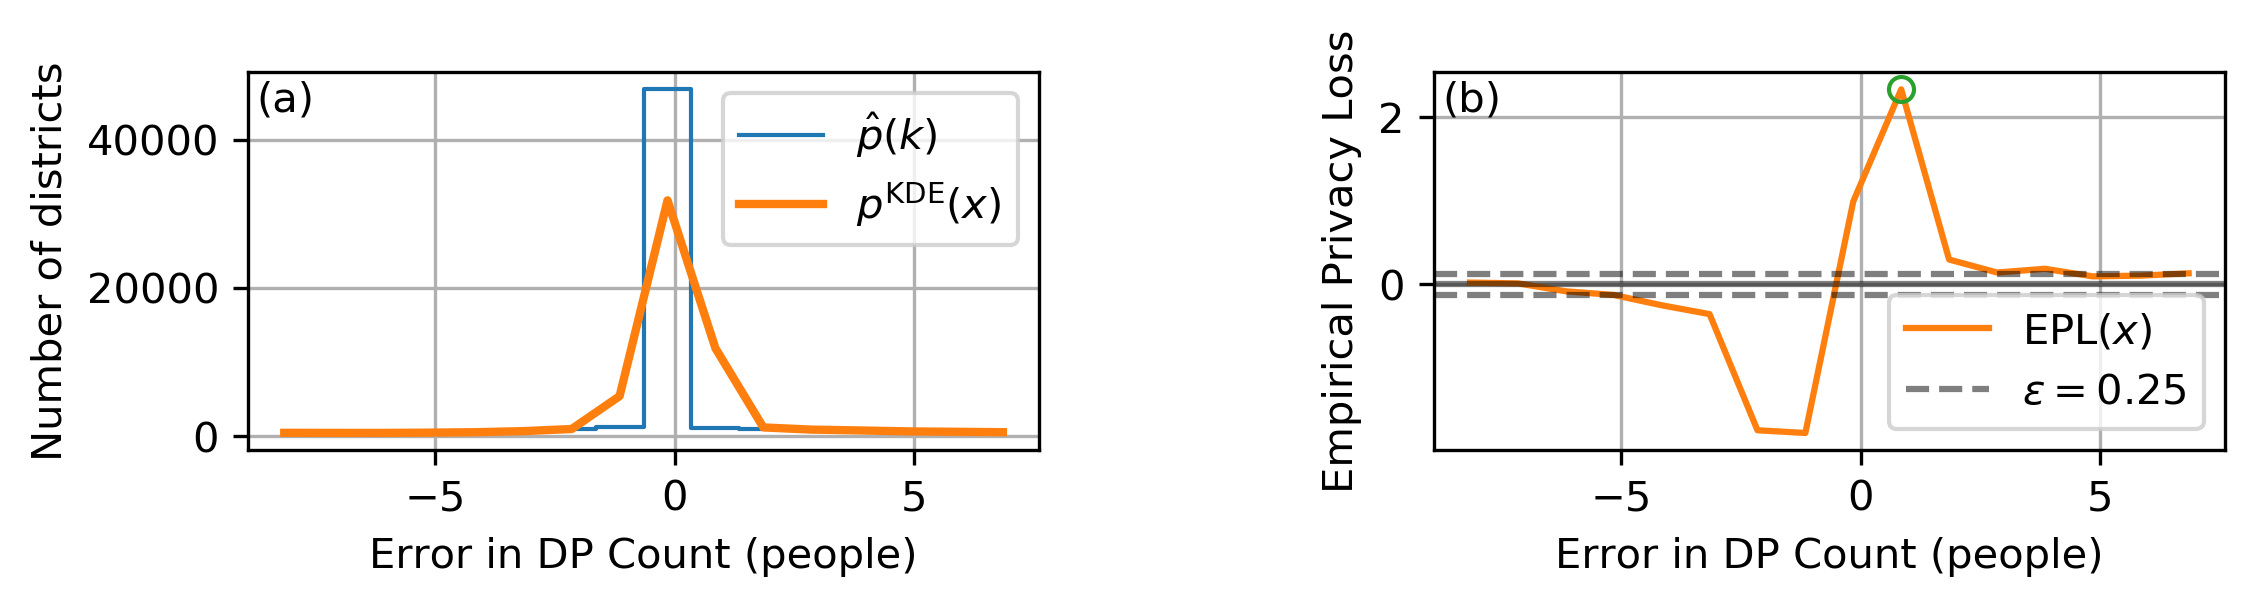

In [31]:
def my_plot(df_epl):
    fig, ax = plt.subplots(ncols=2, figsize=(8.5, 2), dpi=300)
    
    ax[0].plot(df_epl['hist'], linewidth=1, linestyle='-', label='$\\hat{p}(k)$', drawstyle='steps-mid')
    ax[0].plot(df_epl['smooth_hist'], linewidth=2, linestyle='-', label='$p^{\\mathrm{KDE}}(x)$')
    
    ax[0].set_ylabel('Number of districts')
    ax[0].set_xlabel('Error in DP Count (people)')
#     ax[0].set_xlim(-20,30)
    ax[0].grid()
    ax[0].text(.01, .98, '(a)', transform=ax[0].transAxes, ha='left', va='top')
    ax[0].legend(loc='upper right')

    ax[1].plot(df_epl['smooth_epl'], linestyle='-', color='C1', label='$\\mathrm{EPL}(x)$')
    xx = np.absolute(df_epl.smooth_epl).idxmax()
    yy = np.absolute(df_epl.smooth_epl).max()
    ax[1].plot([xx], [yy], 'o', color='none', mec='C2', mew=1)
    
    ax[1].set_ylabel('Empirical Privacy Loss')
    ax[1].set_xlabel('Error in DP Count (people)')
    ax[1].axhline(0, color='k', alpha=.5)
    ax[1].axhline(epsilon/2, color='k', linestyle='--', alpha=.5, label=f'$\\epsilon = {epsilon}$')
    ax[1].axhline(-epsilon/2, color='k', linestyle='--', alpha=.5)
    ax[1].grid()
    ax[1].text(.01, .98, '(b)', transform=ax[1].transAxes, ha='left', va='top')
    ax[1].legend(loc='lower right')
    
    plt.subplots_adjust(wspace=.5, bottom=.25)

my_plot(df_epl)
plt.savefig('fig_SA4_hist_epl.png')

In [32]:
np.absolute(df_epl.smooth_epl).max()

2.325477896832769

In [33]:
2*np.percentile(np.absolute(df_epl.smooth_epl), 50)

0.3233975026710578

In [34]:
np.round(error,1).value_counts()

 0.0     46358
-1.0      1003
-2.0       782
-3.0       464
-4.0       312
         ...  
 30.9        1
-38.2        1
 29.4        1
 51.1        1
 24.7        1
Length: 752, dtype: int64